# Time Series Data Analysis
## Problem statement: 
Analysis and Visualization of Stock Market Data
## Dataset: 
"Stock_Prices.csv"
## Description: 
The dataset contains historical stock price data for a particular company over a period of time. It includes attributes such as date, closing price, volume, and other relevant features. The goal is to perform time series data analysis on the stock price data to identify
trends, patterns, and potential predictors, as well as build models to forecast future stock
prices.
## Tasks to Perform:
1. Import the "Stock_Prices.csv" dataset.
2. Explore the dataset to understand its structure and content.
3. Ensure that the date column is in the appropriate format (e.g., datetime) for time series
analysis.
4. Plot line charts or time series plots to visualize the historical stock price trends over
time.
5. Calculate and plot moving averages or rolling averages to identify the underlying
trends and smooth out noise.
6. Perform seasonality analysis to identify periodic patterns in the stock prices, such as
weekly, monthly, or yearly fluctuations.
7. Analyze and plot the correlation between the stock prices and other variables, such as
trading volume or market indices.
8. Use autoregressive integrated moving average (ARIMA) models or exponential
smoothing models to forecast future stock prices.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

### 1. Import dataset

In [21]:
df = pd.read_csv("Stock_Prices.csv", parse_dates=['Date'])

### 2. Explore dataset

In [3]:
df.shape

(4858, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4858 entries, 0 to 4857
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4858 non-null   object 
 1   Open       4858 non-null   float64
 2   High       4858 non-null   float64
 3   Low        4858 non-null   float64
 4   Close      4858 non-null   float64
 5   Adj Close  4858 non-null   float64
 6   Volume     4858 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 265.8+ KB


In [7]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512


### 3. Convert Date column to datetime

In [22]:
# Ensure Date is datetime and set frequency
df = df.set_index('Date').asfreq('B')   # 'B' = Business Days (stock markets)

In [9]:
# Sort by date just in case
df = df.sort_index()

In [23]:
# Ensure Date column is datetime index
print("Index type:", type(df.index))
print("Index frequency:", df.index.freq)

Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index frequency: <BusinessDay>


### 4. Plot line chart of closing prices

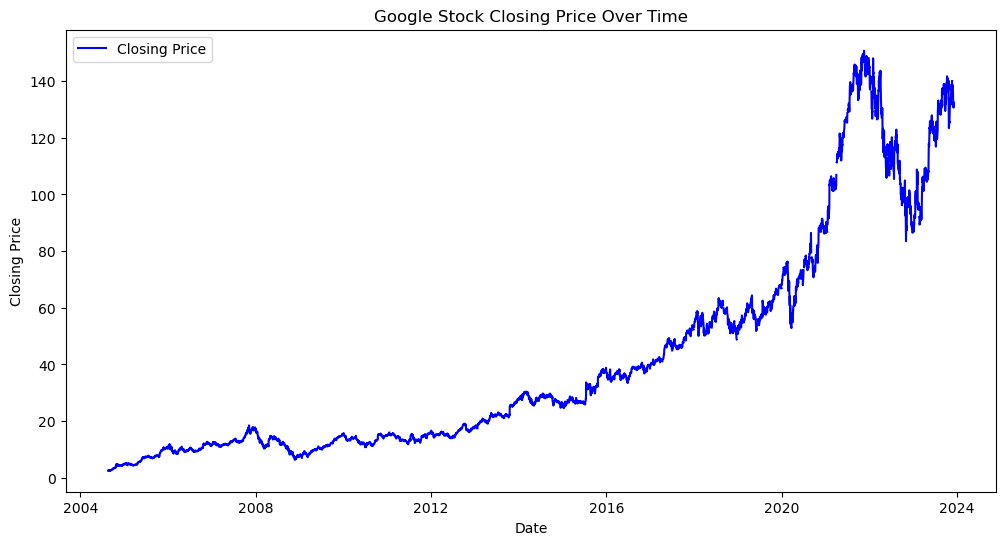

In [24]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label="Closing Price", color="blue")
plt.title("Google Stock Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

### 5. Moving averages

In [25]:
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

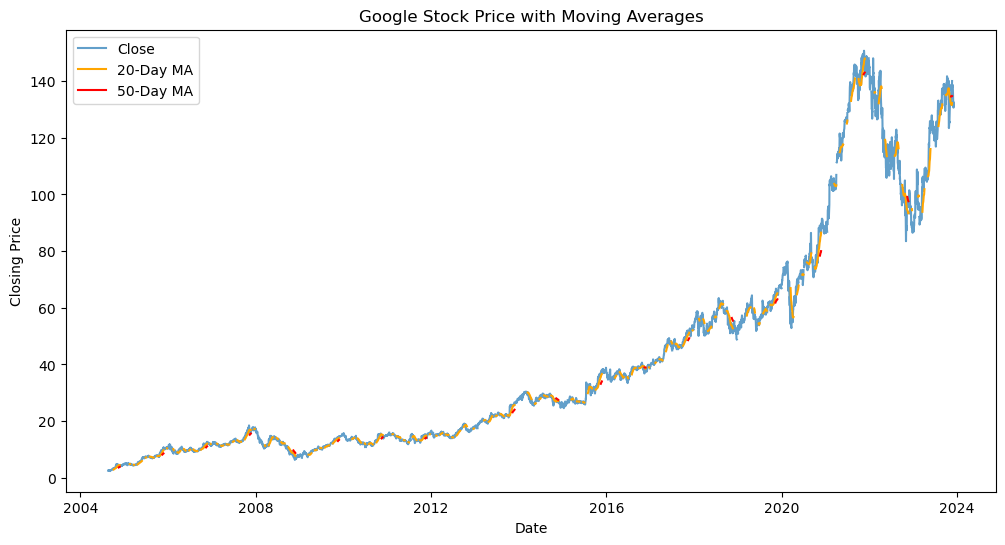

In [26]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label="Close", alpha=0.7)
plt.plot(df['MA20'], label="20-Day MA", color="orange")
plt.plot(df['MA50'], label="50-Day MA", color="red")
plt.title("Google Stock Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

### 6. Seasonality analysis (monthly average closing price)

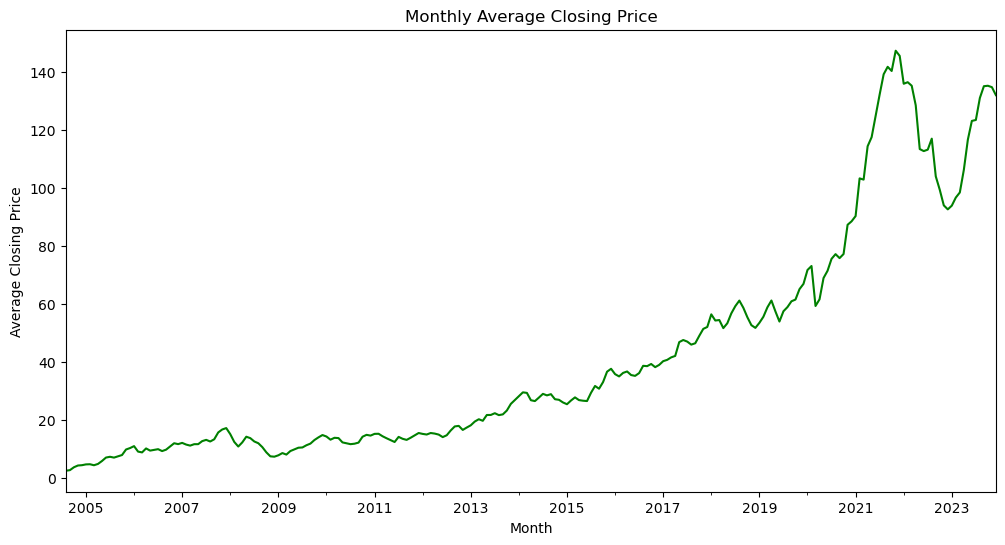

In [27]:
monthly_avg = df['Close'].resample('ME').mean()
plt.figure(figsize=(12,6))
monthly_avg.plot(color='green')
plt.title("Monthly Average Closing Price")
plt.xlabel("Month")
plt.ylabel("Average Closing Price")
plt.show()

### Seasonal decomposition

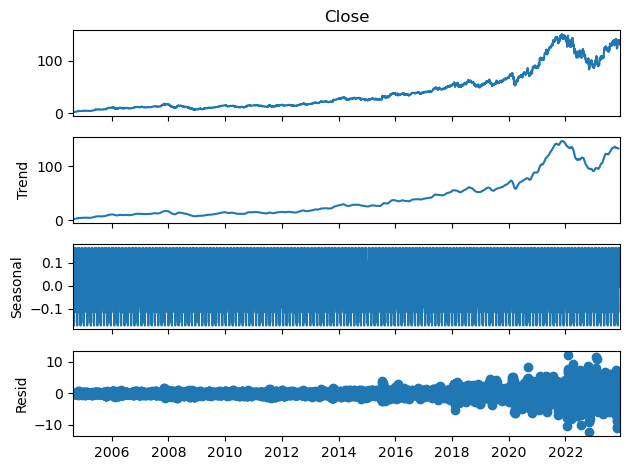

In [28]:
result = seasonal_decompose(df['Close'].dropna(), model='additive', period=30)
result.plot()
plt.show()

### 7. Correlation between closing price and volume

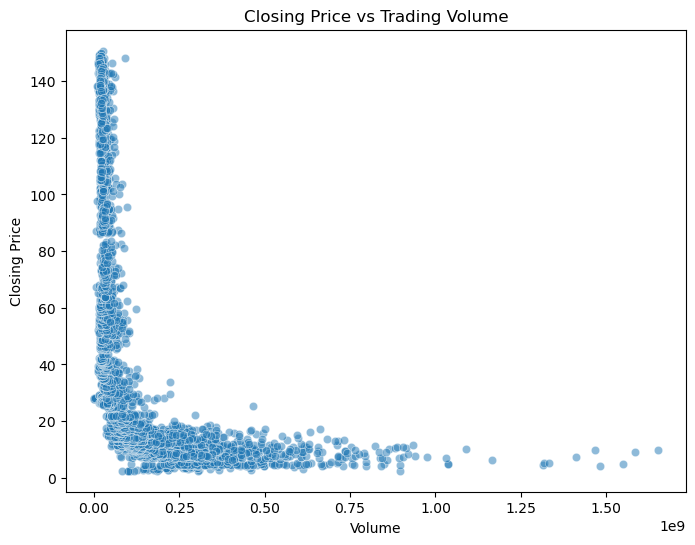

In [29]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['Volume'], y=df['Close'], alpha=0.5)
plt.title("Closing Price vs Trading Volume")
plt.xlabel("Volume")
plt.ylabel("Closing Price")
plt.show()

In [30]:
print("Correlation between Close and Volume:", df['Close'].corr(df['Volume']))

Correlation between Close and Volume: -0.4720174275405003


### 8a. Forecasting with ARIMA
#### Split into train/test

In [31]:
train_size = int(len(df) * 0.8)
train, test = df['Close'][:train_size], df['Close'][train_size:]

#### Fit ARIMA model


In [32]:
arima_model = ARIMA(train, order=(5,1,0))  # (p,d,q)
arima_fit = arima_model.fit()

#### Forecast

In [33]:
forecast_arima = arima_fit.forecast(steps=len(test))

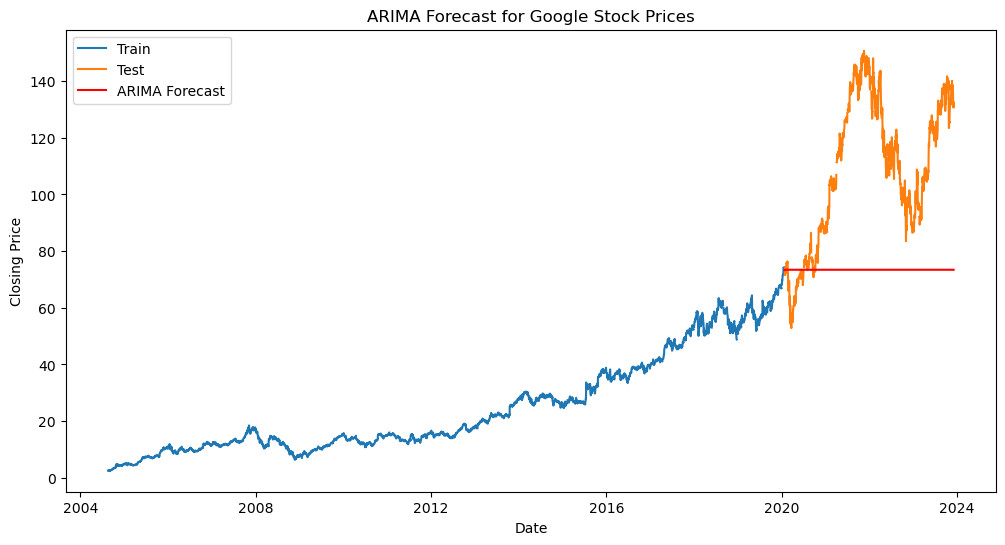

In [34]:
plt.figure(figsize=(12,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(test.index, forecast_arima, label="ARIMA Forecast", color="red")
plt.title("ARIMA Forecast for Google Stock Prices")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

### -----------------------------------
### 9. Numerical forecast values

In [37]:
forecast_df = pd.DataFrame({
    "Actual": test,
    "Forecast_ARIMA": forecast_arima
})
print(forecast_df.head())

               Actual  Forecast_ARIMA
2020-01-27  71.695000       73.315211
2020-01-28  72.627998       73.377113
2020-01-29  72.931503       73.364352
2020-01-30  72.792000       73.364070
2020-01-31  71.711502       73.415081


### 10. Error metrics (to evaluate accuracy)

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Align and drop NaNs from both series
comparison = pd.DataFrame({
    "Actual": test,
    "Forecast": forecast_arima
}).dropna()

mae = mean_absolute_error(comparison["Actual"], comparison["Forecast"])
rmse = np.sqrt(mean_squared_error(comparison["Actual"], comparison["Forecast"]))

print("ARIMA MAE:", mae)
print("ARIMA RMSE:", rmse)

ARIMA MAE: 36.71502846361323
ARIMA RMSE: 43.26082242750591


### 11. Future forecast (beyond test set)
Forecast 30 more business days ahead:

In [40]:
future_forecast = arima_fit.forecast(steps=30)
print("Next 30-day forecast:\n", future_forecast)

Next 30-day forecast:
 2020-01-27    73.315211
2020-01-28    73.377113
2020-01-29    73.364352
2020-01-30    73.364070
2020-01-31    73.415081
2020-02-03    73.416226
2020-02-04    73.409866
2020-02-05    73.410899
2020-02-06    73.411056
2020-02-07    73.408387
2020-02-10    73.408336
2020-02-11    73.408823
2020-02-12    73.408752
2020-02-13    73.408726
2020-02-14    73.408868
2020-02-17    73.408870
2020-02-18    73.408837
2020-02-19    73.408842
2020-02-20    73.408844
2020-02-21    73.408837
2020-02-24    73.408837
2020-02-25    73.408839
2020-02-26    73.408838
2020-02-27    73.408838
2020-02-28    73.408839
2020-03-02    73.408839
2020-03-03    73.408839
2020-03-04    73.408839
2020-03-05    73.408839
2020-03-06    73.408839
Freq: B, Name: predicted_mean, dtype: float64


### 12. Plot with future forecast

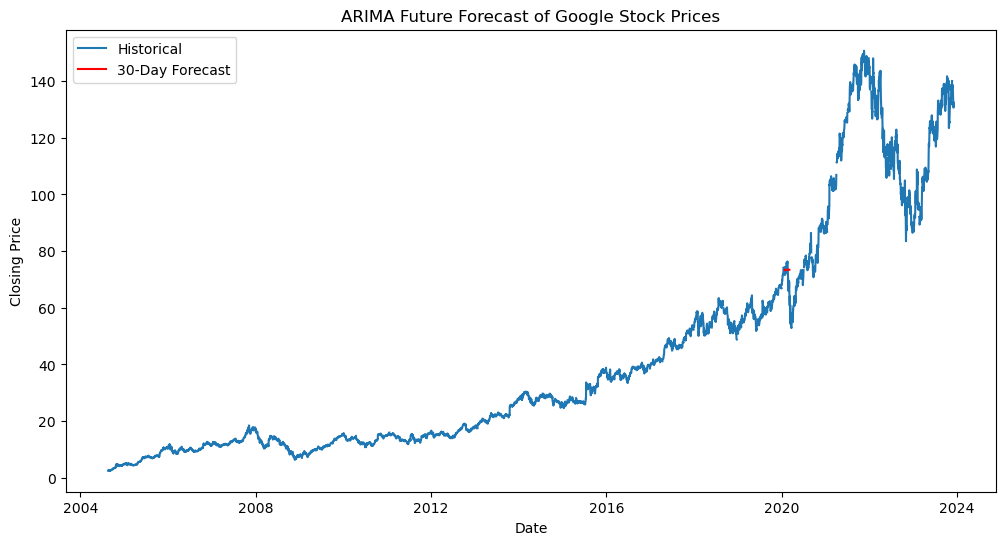

In [41]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label="Historical")
plt.plot(future_forecast.index, future_forecast, label="30-Day Forecast", color="red")
plt.title("ARIMA Future Forecast of Google Stock Prices")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()